In [1]:
from matplotlib import pyplot as plt
import matplotlib
from sklearn import preprocessing
import os
import numpy as np
import random as rd
import tensorflow as tf 
tf.compat.v1.disable_eager_execution()
sess  = tf.compat.v1.InteractiveSession()
from scipy.integrate import odeint
import pickle
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter
import scipy
import joblib

In [2]:
def discrete_toggle_switch(x):
    V1, V2, b1, b2, n, delta = np.array([5, 5, 1, 2, 2, 0.18])
    dt = 0.2
    x_f1 = (1 - delta*dt)*x[0] + V1*dt/(1 + b1*x[1]**n)
    x_f2 = (1 - delta*dt)*x[1] + V2*dt/(1 + b2*x[0]**n)
    return [x_f1, x_f2]


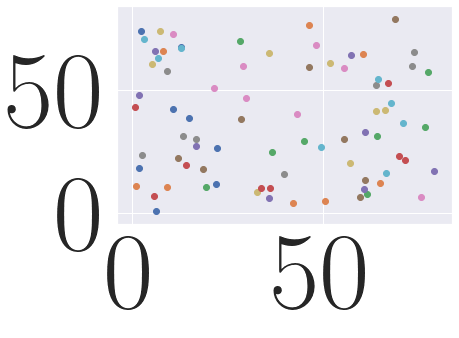

In [59]:
ICs = []
num_ics = 80
for i in range(0, num_ics):
    r = rd.uniform(30, 40)
    theta = rd.uniform(0, 0.5*3.14)
    ICs.append([np.random.uniform(0, 80), np.random.uniform(0, 80)])
    
for i in range(0, num_ics):
    plt.scatter(ICs[i][0],ICs[i][1])

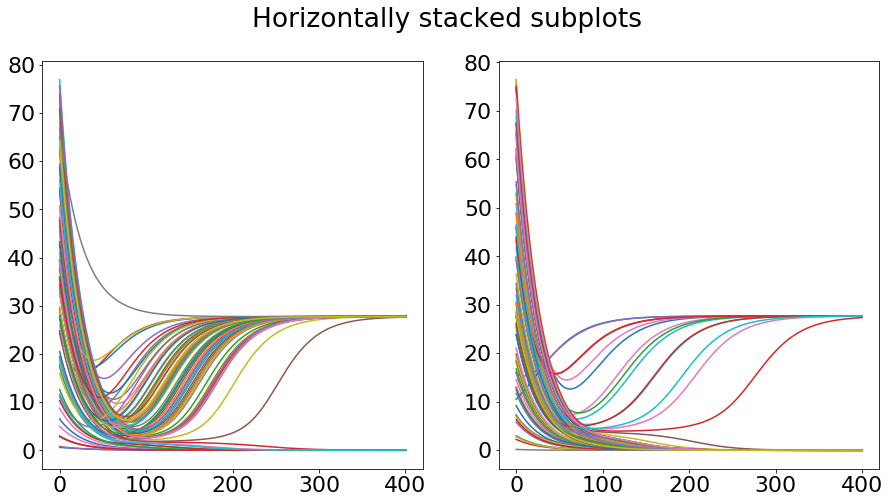

In [8]:
T = 400
matplotlib.rcParams.update({'font.size': 22})

t = np.linspace(0, T, T+1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7.5))
fig.suptitle('Horizontally stacked subplots')
count = 0
for ic in ICs:
    x = np.array([ic[0], ic[1]])
    sol = []
    for i in range(0, T+1):
        y = discrete_toggle_switch(x)
        x = y
        sol.append(x)
    if not count:
        Xp_data = np.array(sol[0:-1]).T
        Xf_data = np.array(sol[1:]).T
    else:
        #print("exec")
        Xp_data = np.hstack([Xp_data, np.array(sol[0:-1]).T])
        Xf_data = np.hstack([Xf_data, np.array(sol[1:]).T])        
    ax1.plot(t, np.array(sol).T[0])
    ax2.plot(t, np.array(sol).T[1])
    count+=1

In [9]:
Xp=tf.compat.v1.placeholder(tf.compat.v1.double, shape = (2, Xp_data.shape[1]))

Xf=tf.compat.v1.placeholder(tf.compat.v1.double, shape = (2, Xf_data.shape[1]))

#n = tf.compat.v1.Variable(np.random.randn(), name = 'n', dtype = tf.double)
#n1 = tf.compat.v1.get_variable('n1',
#                   dtype=tf.double,
#                   shape=(),
#                   initializer=tf.random_uniform_initializer(minval=1., maxval=10.),
#                   constraint=lambda z: tf.clip_by_value(z, 1, 10))

V1 = tf.Variable(tf.compat.v1.truncated_normal((1, ), mean=5,stddev=0.3,dtype=tf.double))
V2 = tf.Variable(tf.compat.v1.truncated_normal((1, ), mean=5,stddev=0.3,dtype=tf.double))
b1 = tf.Variable(tf.compat.v1.truncated_normal((1, ), mean=3,stddev=0.3,dtype=tf.double))
b2 = tf.Variable(tf.compat.v1.truncated_normal((1, ), mean=3,stddev=0.3,dtype=tf.double))

n = tf.Variable(tf.compat.v1.truncated_normal((1, ), mean=3,stddev=0.3,dtype=tf.double))

#n1 = tf.Variable(1.0, dtype = tf.double)

Kx = tf.Variable(tf.compat.v1.truncated_normal((4, 4), mean=0.0,stddev=0.1,dtype=tf.double));
#np.abs(Y - W*b)


#last_col = tf.constant(np.zeros(shape=(3, 1)), dtype=tf.dtypes.double)

#last_col = tf.concat([last_col, [[1.]]], axis=0)

#Kx = tf.concat([Kx, last_col], axis=1)  
#print(Kx)




Instructions for updating:
If using Keras pass *_constraint arguments to layers.


R2 = (1 - tf.divide(tf.math.reduce_sum(tf.math.square(tf.concat([Xf, [Xf[0]**n1]], axis = 0) - tf.math.reduce_mean(tf.concat([Xf, [Xf[0]**n1]], axis = 0), axis=0))), tf.math.reduce_sum(tf.math.square(tf.concat([Xf, [Xf[0]**n1]], axis = 0) - tf.matmul(Kx, tf.concat([Xf, [Xf[0]**n1]], axis = 0)))))) * 100

In [10]:
sess = tf.compat.v1.InteractiveSession();
sess.run(tf.compat.v1.global_variables_initializer());



/Users/dennisjoshy/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [11]:
def generalized_hill_function(X):
    return tf.concat([[V1/(1 + b1*X[0]**n)], [V2/(1 + b2*X[1]**n)]], axis = 0)

In [12]:
def generalized_hill_function_numpy(X):
    return np.vstack([[V1/(1 + b1*X[0]**coop)], [V2/(1 + b2*X[1]**coop)]])

In [13]:
cost = tf.reduce_sum(tf.pow(tf.concat([Xf, generalized_hill_function(Xf)], axis = 0) - tf.matmul(Kx, tf.concat([Xp, generalized_hill_function(Xp)], axis = 0)), 2))/Xp_data.shape[1]


In [14]:
training_epochs = 200000
learning_rate = 0.00050
error_threshold = 0.0000001
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.9, beta2=0.99, epsilon=1e-08, use_locking=False, name='Adam').minimize(cost)
init = tf.compat.v1.global_variables_initializer()
c = 100
epoch = 0
with tf.compat.v1.Session() as sesh:    
    sesh.run(init)    
    #print("Initial n1", sesh.run(n1))
    while epoch < training_epochs and c > error_threshold:
        c = sesh.run(cost, feed_dict = {Xp: np.array(Xp_data), Xf: np.array(Xf_data)})
        if epoch % 5000 == 0:
            print("Epoch:", epoch, "{:.5f}".format(c))
            #print("Exponent", sesh.run(n1))
            #print("R2", sesh.run(R2, feed_dict = {Xp: np.array(Xp_data), Xf: np.array(Xf_data)}))
        sesh.run(optimizer, feed_dict = {Xp: np.array(Xp_data), Xf: np.array(Xf_data)})
        epoch+=1
    KxT_num = sesh.run(Kx)
    #sesh.close()
    print("coop", sesh.run(n))
    coop = sesh.run(n)
    print("V1", sesh.run(V1))
    V1 = sesh.run(V1)
    print("V2", sesh.run(V2))
    V2 = sesh.run(V2)
    print("b1", sesh.run(b1))
    b1 = sesh.run(b1)
    print("b2", sesh.run(b2))
    b2 = sesh.run(b2)
    #print("Exponent", sesh.run(n))
    print(sesh.run(cost, feed_dict = {Xp: np.array(Xp_data), Xf: np.array(Xf_data)}))

Epoch: 0 567.83376
Epoch: 5000 0.00157
Epoch: 10000 0.00019
Epoch: 15000 0.00009
Epoch: 20000 0.00006
Epoch: 25000 0.00004
Epoch: 30000 0.00003
Epoch: 35000 0.00002
Epoch: 40000 0.00002
Epoch: 45000 0.00002
Epoch: 50000 0.00001
Epoch: 55000 0.00001
Epoch: 60000 0.00001
Epoch: 65000 0.00001
Epoch: 70000 0.00001
Epoch: 75000 0.00001
Epoch: 80000 0.00001
Epoch: 85000 0.00001
Epoch: 90000 0.00001
Epoch: 95000 0.00001
Epoch: 100000 0.00001
Epoch: 105000 0.00001
Epoch: 110000 0.00001
Epoch: 115000 0.00001
Epoch: 120000 0.00001
Epoch: 125000 0.00001
Epoch: 130000 0.00001
Epoch: 135000 0.00001
Epoch: 140000 0.00001
Epoch: 145000 0.00000
Epoch: 150000 0.00001
Epoch: 155000 0.00000
Epoch: 160000 0.00000
Epoch: 165000 0.00001
Epoch: 170000 0.00001
Epoch: 175000 0.00000
Epoch: 180000 0.00000
Epoch: 185000 0.00000
Epoch: 190000 0.00000
Epoch: 195000 0.00000
coop [1.99972485]
V1 [0.44799307]
V2 [0.41618367]
b1 [1.99993988]
b2 [0.99993155]
3.714297131242026e-06


In [21]:
V1

array([0.44799307])

In [15]:
KxT_num

array([[ 9.64000502e-01, -3.01748723e-06,  9.21000563e-05,
         2.40265639e+00],
       [ 2.56036686e-06,  9.64002752e-01,  2.23219752e+00,
         5.65737259e-06],
       [ 1.09298169e-05,  4.96617149e-06,  1.00172421e+00,
        -3.61826148e-04],
       [-1.11236857e-04,  7.31378262e-05, -5.35153240e-03,
         1.00752140e+00]])

(4.0, 0.0)

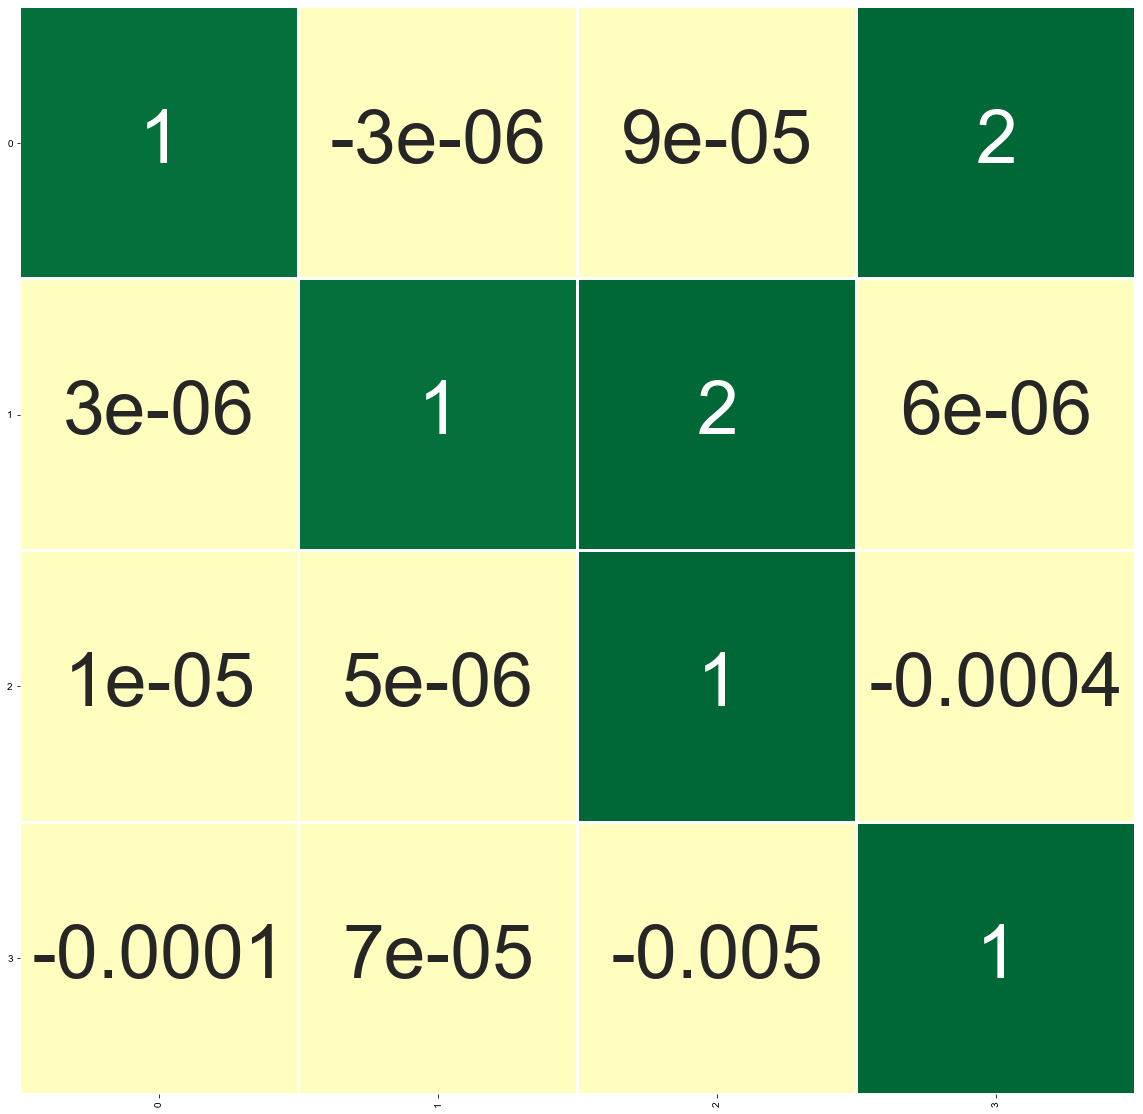

In [16]:


import matplotlib
import seaborn as sns;
matplotlib.rcParams.update({'font.size': 10})
plt.figure(figsize=(20.0,20.0))
ax = sns.heatmap((KxT_num), linewidths=2.0,cmap='RdYlGn',vmin=-1,vmax=1,annot=True,fmt='.1g',cbar=False, annot_kws = {"Size": 75})
bottom, top = ax.get_ylim()
#ax.set_xticklabels(FullInputDictionary_Symbolic,fontsize=25)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.rc('text', usetex=True);
plt.rc('font', family='serif',size=40);
sns.set(font_scale=10) 
bottom, top = ax.get_ylim()
# plt.axis('equal')

ax.set_ylim(bottom + 0.5, top - 0.5)



In [62]:
eigs, eig_vector = np.linalg.eig(KxT_num)

In [89]:
eig_vector@np.diag(eigs**20000)@np.linalg.inv(eig_vector)

array([[ 4.68283653e+13, -6.36503441e+13, -1.02062860e+17,
        -2.59245322e+16],
       [-5.56525171e+13,  7.56443629e+13,  1.21295181e+17,
         3.08096484e+16],
       [-9.41332248e+11,  1.27948352e+12,  2.05164244e+15,
         5.21128551e+14],
       [ 7.35848413e+11, -1.00018449e+12, -1.60378850e+15,
        -4.07371167e+14]])

In [77]:
eigenvalue_matrix = np.diag(eigs)


In [78]:
eigenvalue_matrix

array([[0.97180883, 0.        , 0.        , 0.        ],
       [0.        , 0.96332748, 0.        , 0.        ],
       [0.        , 0.        , 1.00035562, 0.        ],
       [0.        , 0.        , 0.        , 1.00175694]])

In [79]:
eig_vector

array([[ 9.96084323e-01, -5.17783049e-01, -9.80450892e-01,
        -6.43751908e-01],
       [-8.83484389e-02, -8.55511909e-01,  1.96177846e-01,
         7.65057969e-01],
       [-3.10108583e-04,  2.59396547e-04,  3.19605299e-03,
         1.29405421e-02],
       [ 3.23704889e-03,  1.43953998e-04, -1.48352922e-02,
        -1.01157454e-02]])

In [80]:
x_learned = np.array(ic)
X_learned = []
obs = generalized_hill_function_numpy(x_learned).T[0]
for i in range(0, 2000):
    obs = generalized_hill_function_numpy(x_learned).T[0]
    y_learned =  np.matmul(eig_vector@eigenvalue_matrix@np.linalg.inv(eig_vector), np.vstack([x_learned[0], x_learned[1], obs[0], obs[1]]))[0:2]
    x_learned = y_learned#np.array([[y_learned[0], y_learned[1]]])
    X_learned.append([x_learned[0], x_learned[1]]) 

In [81]:
X_learned

[[array([2.87579459]), array([68.46051825])],
 [array([2.77227677]), array([66.05316438])],
 [array([2.67250882]), array([63.73654119])],
 [array([2.57635661]), array([61.50765221])],
 [array([2.48369092]), array([59.36362357])],
 [array([2.39438727]), array([57.30169987])],
 [array([2.30832574]), array([55.31924019])],
 [array([2.22539082]), array([53.41371418])],
 [array([2.14547125]), array([51.58269816])],
 [array([2.06845986]), array([49.82387125])],
 [array([1.99425343]), array([48.13501156])],
 [array([1.92275254]), array([46.51399231])],
 [array([1.85386146]), array([44.95877798])],
 [array([1.78748798]), array([43.46742038])],
 [array([1.72354327]), array([42.03805473])],
 [array([1.66194181]), array([40.66889559])],
 [array([1.60260122]), array([39.35823276])],
 [array([1.54544213]), array([38.10442713])],
 [array([1.49038811]), array([36.90590631])],
 [array([1.4373655]), array([35.76116033])],
 [array([1.38630331]), array([34.66873711])],
 [array([1.33713313]), array([33.62

In [68]:
X_learned = []
x_learned = np.array(ic)
obs = generalized_hill_function_numpy(x_learned).T[0]
for i in range(0, 100):
    y_learned = np.matmul(np.matmul(np.matmul(eig_vector, eigenvalue_matrix ), eig_vector, np.vstack([x_learned[0], x_learned[1], obs[0], obs[1]]))[]
    x_learned = y_learned 
                          

array([[ 1.00650107e+00, -7.48380656e-02, -1.04051572e+00,
        -1.01093648e+00],
       [-1.02945905e-02,  7.49676720e-01, -8.82211581e-02,
        -5.80442813e-01],
       [-2.81365009e-04, -5.50443580e-05,  1.62734521e-04,
         2.95636145e-04],
       [ 3.09307847e-03, -1.75278054e-03, -2.95443467e-03,
        -2.00866417e-03]])

## Discrete model

In [18]:
KxT_num

array([[ 9.64000502e-01, -3.01748723e-06,  9.21000563e-05,
         2.40265639e+00],
       [ 2.56036686e-06,  9.64002752e-01,  2.23219752e+00,
         5.65737259e-06],
       [ 1.09298169e-05,  4.96617149e-06,  1.00172421e+00,
        -3.61826148e-04],
       [-1.11236857e-04,  7.31378262e-05, -5.35153240e-03,
         1.00752140e+00]])

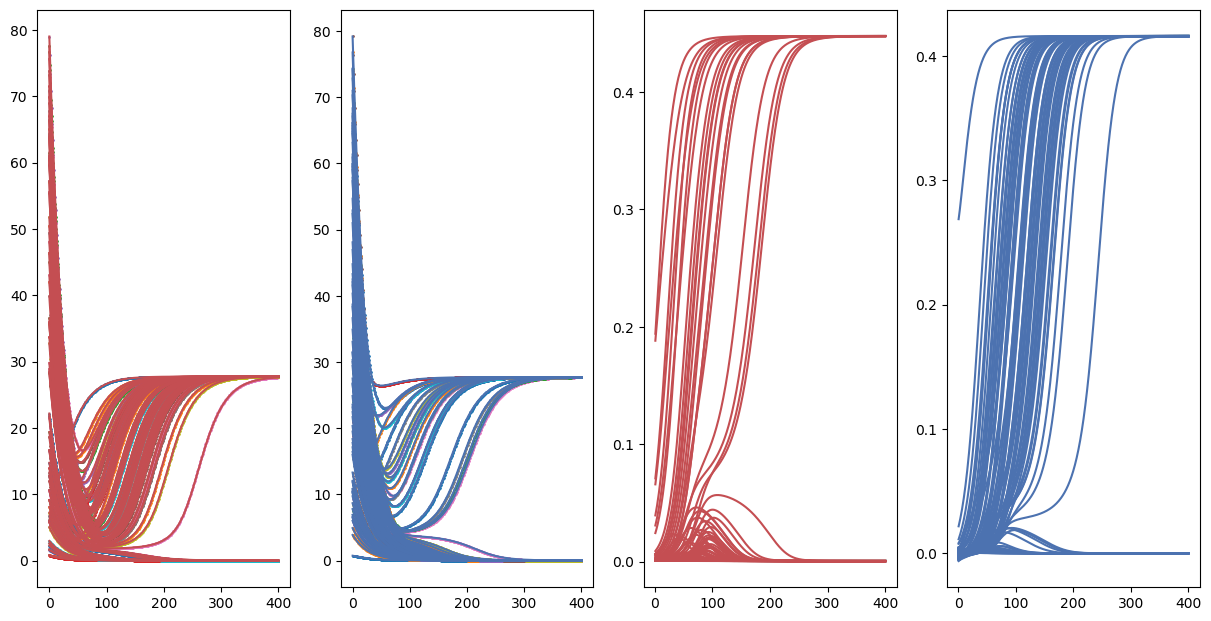

In [88]:
Xp_final_learned = []
Xf_final_learned = []
Xp_final_actual = []
Xf_final_actual = []
#t = np.array([i for i in range(0, N+1)])
matplotlib.rcParams.update({'font.size': 2})
plt.style.use('default')

x_learned = np.zeros(2)
x_actual = np.zeros(2)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,7.5))
#fig.suptitle('Horizontally stacked subplots')
for ic in ICs:
    #ic_s = scaler.transform(np.array([ic]))
    x_learned = np.array(ic)
    x_actual[0] = ic[0]
    x_actual[1] = ic[1]
    X_learned = []
    Y_learned_obs = []
    #print("x_actual", x_actual)
    #print("x_learned", x_learned)
    X_actual = []
    X_learned.append([x_learned[0], x_learned[1]]) ## ICs
    X_actual.append(np.array([x_actual[0], x_actual[1]])) 
    for k in range(0, T):
        obs = generalized_hill_function_numpy(x_learned).T[0]
        y_learned =  np.matmul(KxT_num, np.vstack([x_learned[0], x_learned[1], obs[0], obs[1]]))[0:2]
        y_learned_obs = np.matmul(KxT_num, np.vstack([x_learned[0], x_learned[1], obs[0], obs[1]]))[2:]
        x_learned = y_learned#np.array([[y_learned[0], y_learned[1]]])
        Y_learned_obs.append(y_learned_obs)
        X_learned.append([x_learned[0], x_learned[1]]) 
        y_actual = discrete_toggle_switch(x_actual)
        x_actual = y_actual
        X_actual.append(x_actual)
        #if k % 10 == 0:
            #print(y_learned)
    #print('Plotting')
    ax1.scatter(t, np.array(X_actual).T[0], s = 1)
    ax1.plot(t, np.array(X_learned).T[0], color = 'r')
    ax2.scatter(t, np.array(X_actual).T[1], s = 1)
    ax2.plot(t, np.array(X_learned).T[1], color = 'b')
    ax3.plot(t[1:], np.array(Y_learned_obs).T[0][0], color = 'r')
    #ax2.scatter(t, np.array(X_actual).T[1], s = 1)
    ax4.plot(t[1:], np.array(Y_learned_obs).T[0][1], color = 'b')

In [56]:
np.array(Y_learned_obs).T[0][0].shape

(400,)

In [93]:
x_learned = np.array(ic)
#obs = generalized_hill_function_numpy(x_learned).T[0]
for i in range(0, 50000):
    obs = generalized_hill_function_numpy(x_learned).T[0]
    print(obs)
    y_learned =  np.matmul(KxT_num, np.vstack([x_learned[0], x_learned[1], obs[0], obs[1]]))[0:2]
    x_learned = y_learned#np.array([[y_learned[0], y_learned[1]]])
    X_learned.append([x_learned[0], x_learned[1]]) 

[2.38381737e-02 8.27350233e-05]
[2.55483829e-02 8.88887211e-05]
[2.73729603e-02 9.54835606e-05]
[0.02931832 0.00010255]
[0.03139103 0.00011011]
[0.03359784 0.00011821]
[0.03594561 0.00012686]
[0.03844127 0.00013611]
[0.0410918  0.00014599]
[0.04390417 0.00015654]
[0.04688531 0.00016778]
[0.05004199 0.00017975]
[0.05338079 0.00019249]
[0.05690802 0.00020603]
[0.06062962 0.0002204 ]
[0.06455107 0.00023563]
[0.06867728 0.00025175]
[0.0730125  0.00026878]
[0.07756023 0.00028675]
[0.08232303 0.00030566]
[0.08730251 0.00032552]
[0.09249915 0.00034634]
[0.09791221 0.0003681 ]
[0.10353964 0.00039079]
[0.10937801 0.00041439]
[0.11542239 0.00043884]
[0.12166637 0.0004641 ]
[0.12810194 0.00049011]
[0.13471958 0.00051678]
[0.14150819 0.00054403]
[0.1484552  0.00057174]
[0.15554661 0.00059981]
[0.16276713 0.0006281 ]
[0.17010028 0.00065646]
[0.17752859 0.00068475]
[0.18503375 0.00071281]
[0.19259681 0.00074049]
[0.20019844 0.0007676 ]
[0.2078191 0.000794 ]
[0.21543932 0.00081952]
[0.22303986 0.0008

[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00

[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00

[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00

[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00

[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00

[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00

[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00

[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00

[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00

[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00

[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00

[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00

[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00

[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00

[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00

[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00

[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00

[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00

[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00

[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00

[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00

[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00

[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00

[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00

[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00

[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00

[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00

[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00054175]
[0.44689858 0.00

KeyboardInterrupt: 

In [92]:
generalized_hill_function_numpy(x_learned).T[0]

array([0.44689826, 0.00054176])

In [71]:
X_learned[-1]

[array([0.03497783]), array([27.71228489])]

In [73]:
X_learned[-1]

[array([0.03497783]), array([27.71228489])]

In [75]:
X_learned[-1]

[array([0.03497783]), array([27.71228489])]

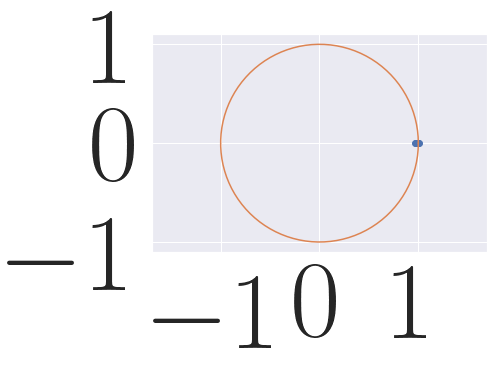

In [43]:
matplotlib.rcParams.update({'font.size': 2})

plt.plot(np.linalg.eigvals(KxT_num), [0]*len(KxT_num),'o')
theta = np.linspace(0,2*np.pi,100)
plt.plot(np.cos(theta),np.sin(theta))
plt.axis('equal')
plt.show()